In [ ]:
%pip install -U langchain_community langchain-openai langchain-anthropic langchain langgraph==0.1.17 tavily-python langchainhub gradio

In [ ]:
!pip install pymongo -qqqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install rich
from rich import print

In [ ]:
from langchain_core.pydantic_v1 import BaseModel
from typing import TypedDict, Annotated, List
from rich import print

class Attributes(BaseModel):
    attributes: List[str]

In [ ]:
format_instructions = Attributes.schema()["title"]
format_instructions

'Attributes'

In [ ]:
from langchain_openai import ChatOpenAI
from google.colab import userdata

model = ChatOpenAI(model="gpt-4o", temperature=0.2, openai_api_key=userdata.get('openai'))

### Get Attributes

In [ ]:
RESEARCH_PROMPT = """

##Your Role:
You are an expert in Recommendation Systems, particularly in the Upselling domain. Your task is to analyze the product category and create a comprehensive list of attributes that a user can use to compare the provided product with higher-end models.

##Task:

Identify the category of the product (e.g., "BMW 328i belongs to Luxury Sedan Cars").
Develop a list of up to 10 key attributes, each with a brief one-line description, that a user would consider when comparing the product to more expensive or higher-end models.
Example:

```
{
  "Attribute 1": "Description 1",
  "Attribute 2": "Description 2",
  ...
  "Attribute 10": "Description 10"
}
```

"""

from typing import TypedDict, Annotated, List

class AgentState(TypedDict):
    user_query: str
    attribute_results: List[str]
    high_end_model_summarization: List[str]
    high_end_model_comparison: List[str]
    review_comments: str
    draft_number: int
    max_reviews: int

import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

def get_attribute_node(state: AgentState):
  print ("Research Agent executing ...")
  input_message = "User query: " + state['user_query']
  draft_number = 0
  messages = model.with_structured_output(Attributes).invoke([
        SystemMessage(content=RESEARCH_PROMPT),
        HumanMessage(content=input_message)
    ])
  #response = model.invoke(messages)
  return {"attribute_results": messages.attributes, "draft_number": draft_number}

### Get High End Models

In [ ]:
from dataclasses import Field
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import TypedDict, Annotated, List
from langchain_core.output_parsers import PydanticOutputParser

class high_end_product(BaseModel):
    original_product: str = Field(title="Original Product", description="Summarization for Original Product")
    product1: str = Field(title="Product 1", description="Summarization Product 1")
    product2: str = Field(title="Product 2", description="Summarization Product 2")
    product3: str = Field(title="Product 3", description="Summarization Product 3")
    product4: str = Field(title="Product 4", description="Summarization Product 4")


pydantic_parser  = PydanticOutputParser(pydantic_object=high_end_product)
format_instructions = pydantic_parser.get_format_instructions()
format_instructions



'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"original_product": {"title": "Original Product", "description": "Summarization for Original Product", "type": "string"}, "product1": {"title": "Product 1", "description": "Summarization Product 1", "type": "string"}, "product2": {"title": "Product 2", "description": "Summarization Product 2", "type": "string"}, "product3": {"title": "Product 3", "description": "Summarization Product 3", "type": "string"}, "product4": {"title": "Product 4", "description": "Summarization Product 4", "type": "string"}}, "required": ["orig

In [ ]:
from typing_extensions import final




def get_high_end_model(state: AgentState):
  HIGH_END_PRODUCTS_PROMPT = """

    ##Your Role:
    You are expert Technical Sales agent who has a knowledge of variety of products,and details about them and you know everything a customer want to know before buying a product. Your task is to analyze the product category and create a comprehensive list of attributes that a user can use to compare the provided product with higher-end models.

    ##Task:

    - Identify the price of user given product.
    - Indentify atmost 4 high end products from the one user suggested. It can be from the same brand or other brands. The key is they should be comparable. **The price of high end models should be higher the exact price of all items**
    - Summarize the finding for each product in DETAIL, including the original user given product.
    - Make sure the summary **covers all the aspects of this attribute list {attributes} in DETAIL**. Summary should be between 300 words

    ##Output Format: {format_instructions}
    ```json
    {{
      "orignal_product": "orignal_product: Original PRODUCT Price: Summarization for Original Product",
      "product1": "Product Name1: Product1 Price : Summarization Product 1",
      "product2": "Product Name2: Product2 Price : Summarization Product 2",
      "product3": "Product Name3: Product3 Price : Summarization Product 3",
      "product4": "Product Name4: Product4 Price : Summarization Product 4"
    }}
    ```
    Make sure each product price is higher thant the original product price and its explicitly mentioned in the output.
    """


  REVISE_HIGH_END_PRODUCTS_PROMPT = """
    ##Your Role:
    You are expert Technical Sales agent who has a knowledge of variety of products,and details about them and you know everything a customer want to know before buying a product. Your task is to analyze the product category and create a comprehensive list of attributes that a user can use to compare the provided product with higher-end models.

    ##Your Task:
    - This is the draft comparing original product with high end models. {high_end_comparisons}
    - review the comments for each product {reviews},
    - if its satisfied, great return the same product with the same summary, DO NOT CHANGE ANYTHING
    - if not, act on the advise, and make necessary changes using the below guidelines.

    ### Guidelines:
    - Identify the price of user given product.
    - Indentify what the advise is for a particular product, if it needs clarification; provide to address the issue and return the same product with the necessary changes.
    - if price lower is the issue and identify a new product, summarize the product in DETAIL. Make sure the summary covers all the aspects of this attribute list {attributes} in DETAIL. Summary should be between 300 words

    ## Updated High End Products Summary:
    ###Output Format: {format_instructions}
    ```json
    {{
      "orignal_product": "orignal_product: Original PRODUCT Price: Summarization for Original Product",
      "product1": "Product Name1: Product1 Price : Summarization Product 1",
      "product2": "Product Name2: Product2 Price : Summarization Product 2",
      "product3": "Product Name3: Product3 Price : Summarization Product 3",
      "product4": "Product Name4: Product4 Price : Summarization Product 4"
    }}
    ```
    Make sure each product price is higher thant the original product price and its explicitly mentioned in the output.


  """
  attribute_list = ";".join(state['attribute_results'] or [])
  user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
  if (state['review_comments'] is not None and state['review_comments'] != ""):
    print ("Revising High End Models ...")
    final_prompt = REVISE_HIGH_END_PRODUCTS_PROMPT.format(
        high_end_comparisons=state['high_end_model_comparison'],
        reviews=state['review_comments'],
        attributes=attribute_list,
        format_instructions=format_instructions)
  else:
    print ("Getting High End Models ...")
    final_prompt = HIGH_END_PRODUCTS_PROMPT.format(attributes=attribute_list, format_instructions=format_instructions)
  response = model.invoke([
        SystemMessage(content=final_prompt),
        user_message
    ])
  output_summarization = response.content
  final_output_summarization = pydantic_parser.parse(output_summarization)
  return {"high_end_model_summarization": final_output_summarization}

### High End Model Comparison

In [ ]:
class high_end_product_comparison(BaseModel):
    original_product: str = Field(title="Original Product", description="Summarizing for Original Product")
    product1: str = Field(title="Product 1", description="Summarizing why paying higher for product 1 is better")
    product2: str = Field(title="Product 2", description="Summarizing why paying higher for product 2 is better")
    product3: str = Field(title="Product 3", description="Summarizing why paying higher for product 3 is better")
    product4: str = Field(title="Product 4", description="Summarizing why paying higher for product 4 is better")


pydantic_parser_comparison  = PydanticOutputParser(pydantic_object=high_end_product_comparison)
format_instructions_comparison = pydantic_parser_comparison.get_format_instructions()
format_instructions_comparison

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"original_product": {"title": "Original Product", "description": "Summarizing for Original Product", "type": "string"}, "product1": {"title": "Product 1", "description": "Summarizing why paying higher for product 1 is better", "type": "string"}, "product2": {"title": "Product 2", "description": "Summarizing why paying higher for product 2 is better", "type": "string"}, "product3": {"title": "Product 3", "description": "Summarizing why paying higher for product 3 is better", "type": "string"}, "product4": {"title": "Prod

In [ ]:
def get_high_end_model_comparison(state: AgentState):
  HIGH_END_PRODUCTS_COMPARISON_PROMPT = """

    ##Your Role:
    You are expert critique agent who is expert in reading a lot of product summarization and ability to distinctly identify key qualities of a product.
    ##Task: Here is the summary for the original product and its high end models. {high_end_models}

    - Understand the original products and its features and qualities.
    - Compare and reason out why paying higher price for a product is better than the original product.
    - List key points with clarity that make it worth paying for the higher end model.
    - **Each listed point should directly compare with the original product**

    ##Output Format: {format_instructions}
    ```
    {{
      "orignal_product": "Original PRODUCT Price: Summarization for Original Product",
      "product1": "Product Name1: Price:  <Reason for why paying higher for product 1 is better in bullet points>",
      "product2": "Product Name2: Price:  <Reason for why paying higher for product 2 is better in bullet points>",
      "product3": "Product Name3: Price:  <Reason for why paying higher for product 3 is better in bullet points>",
      "product4": "Product Name4: Price:  <Reason for why paying higher for product 4 is better in bullet points>"
    }}

    Make sure each product is compared with the original product. Make sure its a json in the output format provided
    """
  high_end_models = ";".join(str(item) for item in (state['high_end_model_summarization'] or []))
  user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
  final_prompt = HIGH_END_PRODUCTS_COMPARISON_PROMPT.format(high_end_models=high_end_models, format_instructions=format_instructions_comparison)
  response = model.invoke([
        SystemMessage(content=final_prompt),
        user_message
    ])
  output = response.content
  final_output = pydantic_parser_comparison.parse(output)
  if (state.get("draft_number") is not None):
      draft_number = state.get("draft_number")

  return {"high_end_model_comparison": final_output,
          "draft_number": draft_number + 1}

### Reflection Node

In [ ]:
class reflection_on_comparison(BaseModel):
    original_product: str = Field(title="Original Product", description="Summarizing for Original Product")
    product1: str = Field(title="Product 1", description="Review Comments for product 1")
    product2: str = Field(title="Product 2", description="Review Comments for product 2")
    product3: str = Field(title="Product 3", description="Review Comments for product 3")
    product4: str = Field(title="Product 4", description="Review Comments for product 4")

pydantic_parser_reflection  = PydanticOutputParser(pydantic_object=reflection_on_comparison)
format_instructions_reflection = pydantic_parser_reflection.get_format_instructions()
format_instructions_reflection

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"original_product": {"title": "Original Product", "description": "Summarizing for Original Product", "type": "string"}, "product1": {"title": "Product 1", "description": "Review Comments for product 1", "type": "string"}, "product2": {"title": "Product 2", "description": "Review Comments for product 2", "type": "string"}, "product3": {"title": "Product 3", "description": "Review Comments for product 3", "type": "string"}, "product4": {"title": "Product 4", "description": "Review Comments for product 4", "type": "string"

In [ ]:


def reflection_node(state: AgentState):
    REFLECTION_PROMPT = """

    ##Your Role:
    You are an expert in Recommendation Systems, particularly in the Upselling domain. Your task is analyze the output of recommendations provided to you. You would want to make sure overall
    objective of maximize revenue by encouraging customers to purchase higher-value products or add-on items that complement their existing purchase intentions is achieved

    This is the draft comparing original product with high end models. {draft_summarization}

    ##Task:
    1. Make sure the price of the higher end items are higher than the original product price
    2. Make sure if the reasoning provided is correct or not.
    3. if convinced return "Satisfied" and if you are not convinced the reasoning  provided to for that product. Include the product name in the review.
    4. Advise to change the product if price is lower than the original product price.
    5. Do not provide more context about the product, the task is to **JUDGE** if you are satisfied or not and the high price condition is met.

    ## Output Format: {format_instructions}
    ```json
    {{
      "product1": "Review Comments for product 1 it should be satisfied or the review",
      "product2": "Review Comments for product 2 it should be satisfied or the review",
      "product3": "Review Comments for product 3 it should be satisfied or the review",
      ...
      "product4": "Review Comments for product 4 it should be satisfied or the review"
    }}
    ```

    Make sure each product is compared with the original product. Make sure its a json in the output format provided
    """
    print ("Review Agent executing ...")
    #draft_summarization = ";".join(state['high_end_model_comparison'] or [])
    print(state['high_end_model_comparison'])
    draft_summarization = ";".join(str(item) for item in (state['high_end_model_comparison'] or []))
    user_message = HumanMessage(content=f"The user query is - {state['user_query']}")
    final_prompt_reflection = REFLECTION_PROMPT.format(draft_summarization=draft_summarization, format_instructions=format_instructions_reflection)
    response = model.invoke([
          SystemMessage(content=final_prompt_reflection),
          user_message
      ])
    output_reflection = response.content
    final_output_reflection = pydantic_parser_reflection.parse(output_reflection)

    return {"review_comments": final_output_reflection}

def agent_goal(state: AgentState):
  draft_number = state["draft_number"]
  max_reviews = state["max_reviews"]
  output_reflection = state["review_comments"]
  if draft_number > max_reviews:
    print ("End of Agent Execution")
    return "AGENT_END"
  elif output_reflection.product1 == "Satisfied" and output_reflection.product2 == "Satisfied" and output_reflection.product3 == "Satisfied" and output_reflection.product4 == "Satisfied":
    print ("End of Agent Execution since all products are satisfied")
    return "AGENT_END"
  else:
    print ("Continue Agent Execution")
    return "AGENT_CONTINUE"

## Running an Agent

In [ ]:
from langgraph.graph import StateGraph, END

upsell_graph = StateGraph(AgentState)
upsell_graph.add_node("get_attributes", get_attribute_node)
upsell_graph.add_node("get_high_end_model", get_high_end_model)
upsell_graph.add_node("get_high_end_model_comparison", get_high_end_model_comparison)
upsell_graph.add_node("reflection", reflection_node)




upsell_graph.add_edge("get_attributes", "get_high_end_model")
upsell_graph.add_edge("get_high_end_model", "get_high_end_model_comparison")
upsell_graph.add_edge("get_high_end_model_comparison", "reflection")
upsell_graph.add_conditional_edges("reflection", agent_goal, {"AGENT_END": END, "AGENT_CONTINUE": "get_high_end_model"})


In [ ]:
upsell_graph.set_entry_point("get_attributes")


In [ ]:
upsell_recommendation_agent = upsell_graph.compile()

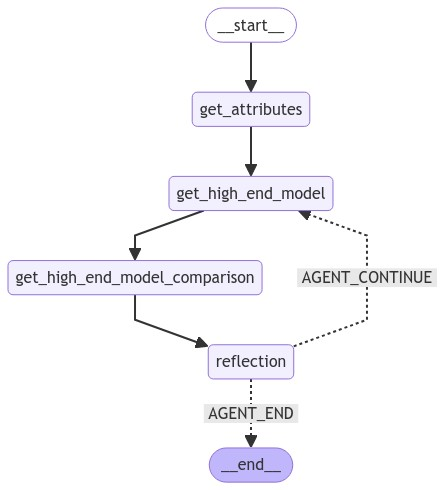

In [ ]:
from IPython.display import Image, display

display(Image(upsell_recommendation_agent.get_graph().draw_mermaid_png()))

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = userdata.get('lsmith')
os.environ['LANGCHAIN_PROJECT'] = "agent_report"

In [ ]:
output = upsell_recommendation_agent.invoke({'user_query': "InSinkErator Badger 500, 1/2 HP Continuous Feed Kitchen Garbage Disposal, Standard Series",
                                  "max_reviews": 2,})

#"Traeger Pro Blend All-Natural Wood Grilling Pellets"
#"Dasani Water"
#"Pampers Baby Diaper"
#""GE Profile 4.8 cu. ft. Smart UltraFast Electric Washer & Dryer Combo""
#"HDX Superior Pleated Furnace Air Filter FPR 9"

Research Agent executing ...

Getting High End Models ...

Review Agent executing ...

high_end_product_comparison(
    original_product='InSinkErator Badger 500: $99 - The InSinkErator Badger 500 is a reliable and affordable 
kitchen garbage disposal unit. It features a 1/2 horsepower Dura-Drive induction motor, which provides a powerful 
and consistent grind. The continuous feed mechanism allows for the disposal of food waste without interruption. The
unit is part of the Standard Series, which is known for its durability and ease of installation. The Badger 500 is 
constructed with galvanized steel components, ensuring long-lasting performance. It also includes a Quick Lock sink
mount for easy replacement and installation. However, it lacks advanced noise reduction technology and 
corrosion-resistant materials found in higher-end models.',
    product1='InSinkErator Evolution Compact: $200 - \n- More powerful 3/4 horsepower motor compared to the 1/2 
horsepower motor in the Badger 500.\n- Includes SoundSeal technology for significantly reduced noise during 
operation, unlike the Badger 500.\n- Features MultiGrind technology for a finer grind, reducing the risk of clogs, 
which the Badger 500 lacks.\n- Constructed with stainless steel components for superior durability and corrosion 
resistance compared to the galvanized steel in the Badger 500.\n- Compact design suitable for smaller spaces, 
offering more flexibility in installation.',
    product2='Waste King L-8000: $150 - \n- More powerful 1 horsepower permanent magnet motor compared to the 1/2 
horsepower motor in the Badger 500.\n- Includes sound insulation to reduce noise during operation, which the Badger
500 lacks.\n- Constructed with stainless steel components for better durability and corrosion resistance compared 
to the galvanized steel in the Badger 500.\n- Comes with a removable splash guard for easier cleaning and 
maintenance, a feature not mentioned for the Badger 500.\n- Pre-installed power cord for straightforward 
installation, unlike the Badger 500 which does not mention this feature.',
    product3='Moen GX100C Host Series: $180 - \n- More powerful 1 horsepower Vortex motor compared to the 1/2 
horsepower motor in the Badger 500.\n- Includes SoundSHIELD technology to reduce noise during operation, unlike the
Badger 500.\n- Constructed with stainless steel components for superior durability and corrosion resistance 
compared to the galvanized steel in the Badger 500.\n- Pre-installed power cord and Universal Xpress Mount for 
easier installation, features not mentioned for the Badger 500.\n- Designed for heavy use, making it more suitable 
for households that frequently cook and entertain.',
    product4='GE GFC1020N: $170 - \n- More powerful 1 horsepower motor compared to the 1/2 horsepower motor in the 
Badger 500.\n- Includes sound insulation to reduce noise during operation, which the Badger 500 lacks.\n- 
Constructed with stainless steel components for better durability and corrosion resistance compared to the 
galvanized steel in the Badger 500.\n- Comes with a removable splash guard for easier cleaning and maintenance, a 
feature not mentioned for the Badger 500.\n- Direct wire connection for straightforward installation, unlike the 
Badger 500 which does not mention this feature.'
)

End of Agent Execution since all products are satisfied

In [ ]:

print(output)

{
    'user_query': 'InSinkErator Badger 500, 1/2 HP Continuous Feed Kitchen Garbage Disposal, Standard Series',
    'attribute_results': [
        'InSinkErator Badger 500',
        '1/2 HP',
        'Continuous Feed',
        'Kitchen Garbage Disposal',
        'Standard Series'
    ],
    'high_end_model_summarization': high_end_product(
        original_product='InSinkErator Badger 500: $99 - The InSinkErator Badger 500 is a reliable and affordable 
kitchen garbage disposal unit. It features a 1/2 horsepower Dura-Drive induction motor, which provides a powerful 
and consistent grind. The continuous feed mechanism allows for the disposal of food waste without interruption. The
unit is part of the Standard Series, which is known for its durability and ease of installation. The Badger 500 is 
constructed with galvanized steel components, ensuring long-lasting performance. It also includes a Quick Lock sink
mount for easy replacement and installation. However, it lacks advanced noise reduction technology and 
corrosion-resistant materials found in higher-end models.',
        product1='InSinkErator Evolution Compact: $200 - The InSinkErator Evolution Compact is a higher-end model 
compared to the Badger 500. It features a 3/4 horsepower Dura-Drive induction motor, providing more power for 
tougher food waste. The unit includes SoundSeal technology, which significantly reduces noise during operation. The
MultiGrind technology allows for a finer grind, reducing the risk of clogs. The Evolution Compact is made with 
stainless steel components, offering superior durability and corrosion resistance. It also has a compact design, 
making it suitable for smaller spaces. The Quick Lock sink mount is included for easy installation.',
        product2='Waste King L-8000: $150 - The Waste King L-8000 is another high-end garbage disposal unit. It 
features a 1 horsepower permanent magnet motor, which provides a powerful and efficient grind. The continuous feed 
mechanism allows for uninterrupted disposal of food waste. The unit includes sound insulation, reducing noise 
during operation. The L-8000 is constructed with stainless steel components, ensuring durability and corrosion 
resistance. It also includes a removable splash guard for easy cleaning and maintenance. The Waste King L-8000 
comes with a pre-installed power cord, making installation straightforward.',
        product3='Moen GX100C Host Series: $180 - The Moen GX100C Host Series is a premium garbage disposal unit 
designed for heavy use. It features a 1 horsepower Vortex motor, providing powerful grinding capabilities. The 
continuous feed mechanism allows for the disposal of large amounts of food waste without interruption. The unit 
includes SoundSHIELD technology, which reduces noise during operation. The GX100C is made with stainless steel 
components, offering durability and corrosion resistance. It also includes a pre-installed power cord and a 
Universal Xpress Mount for easy installation. The Moen GX100C is designed for households that frequently cook and 
entertain.',
        product4='GE GFC1020N: $170 - The GE GFC1020N is a high-end garbage disposal unit with a 1 horsepower 
motor. It features a continuous feed mechanism, allowing for the disposal of food waste without interruption. The 
unit includes sound insulation, reducing noise during operation. The GFC1020N is constructed with stainless steel 
components, ensuring durability and corrosion resistance. It also includes a removable splash guard for easy 
cleaning and maintenance. The GE GFC1020N comes with a direct wire connection, making installation straightforward.
This model is designed for households that require a powerful and reliable garbage disposal unit.'
    ),
    'high_end_model_comparison': high_end_product_comparison(
        original_product='InSinkErator Badger 500: $99 - The InSinkErator Badger 500 is a reliable and affordable 
kitchen garbage disposal unit. It features a 1/2 horsepower Dura-

In [ ]:
from rich import print
print(output['high_end_model_comparison'].product1)

InSinkErator Evolution Compact: $200 - 
- More powerful 3/4 horsepower motor compared to the 1/2 horsepower motor in the Badger 500.
- Includes SoundSeal technology for significantly reduced noise during operation, unlike the Badger 500.
- Features MultiGrind technology for a finer grind, reducing the risk of clogs, which the Badger 500 lacks.
- Constructed with stainless steel components for superior durability and corrosion resistance compared to the 
galvanized steel in the Badger 500.
- Compact design suitable for smaller spaces, offering more flexibility in installation.

In [ ]:
from rich import print
print(output['high_end_model_comparison'].product2)

Waste King L-8000: $150 - 
- More powerful 1 horsepower permanent magnet motor compared to the 1/2 horsepower motor in the Badger 500.
- Includes sound insulation to reduce noise during operation, which the Badger 500 lacks.
- Constructed with stainless steel components for better durability and corrosion resistance compared to the 
galvanized steel in the Badger 500.
- Comes with a removable splash guard for easier cleaning and maintenance, a feature not mentioned for the Badger 
500.
- Pre-installed power cord for straightforward installation, unlike the Badger 500 which does not mention this 
feature.

In [ ]:
from rich import print
print(output['high_end_model_comparison'].product3)

Moen GX100C Host Series: $180 - 
- More powerful 1 horsepower Vortex motor compared to the 1/2 horsepower motor in the Badger 500.
- Includes SoundSHIELD technology to reduce noise during operation, unlike the Badger 500.
- Constructed with stainless steel components for superior durability and corrosion resistance compared to the 
galvanized steel in the Badger 500.
- Pre-installed power cord and Universal Xpress Mount for easier installation, features not mentioned for the 
Badger 500.
- Designed for heavy use, making it more suitable for households that frequently cook and entertain.

In [ ]:
from rich import print
print(output['high_end_model_comparison'].product4)

GE GFC1020N: $170 - 
- More powerful 1 horsepower motor compared to the 1/2 horsepower motor in the Badger 500.
- Includes sound insulation to reduce noise during operation, which the Badger 500 lacks.
- Constructed with stainless steel components for better durability and corrosion resistance compared to the 
galvanized steel in the Badger 500.
- Comes with a removable splash guard for easier cleaning and maintenance, a feature not mentioned for the Badger 
500.
- Direct wire connection for straightforward installation, unlike the Badger 500 which does not mention this 
feature.

In [ ]:
print(output['high_end_model_comparison'].original_product)

InSinkErator Badger 500: $99 - The InSinkErator Badger 500 is a reliable and affordable kitchen garbage disposal 
unit. It features a 1/2 horsepower Dura-Drive induction motor, which provides a powerful and consistent grind. The 
continuous feed mechanism allows for the disposal of food waste without interruption. The unit is part of the 
Standard Series, which is known for its durability and ease of installation. The Badger 500 is constructed with 
galvanized steel components, ensuring long-lasting performance. It also includes a Quick Lock sink mount for easy 
replacement and installation. However, it lacks advanced noise reduction technology and corrosion-resistant 
materials found in higher-end models.